# viz

In [8]:
import numpy as np 
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import torch
import seaborn as sns
from sklearn.decomposition import PCA

plt.matplotlib.style.use("https://gist.githubusercontent.com/JonnyCBB/c464d302fefce4722fe6cf5f461114ea/raw/64a78942d3f7b4b5054902f2cee84213eaff872f/matplotlibrc")
cool_colors = ['#00BEFF', '#D4CA3A', '#FF6DAE', '#67E1B5', '#EBACFA', '#9E9E9E', '#F1988E', '#5DB15A', '#E28544', '#52B8AA']
cool_colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']

plt.rcParams.update({'font.size': 14})

search_to_color = {'BO': cool_colors[0], 'random': cool_colors[1], 'evolutionary': cool_colors[2], 'RF': cool_colors[3], 'RF (div)': cool_colors[5]}

## load in data
load data from `prepare_Xy.ipynb`

In [9]:
X = pickle.load(open('inputs_and_outputs.pkl', 'rb'))['X']
print("shape of X:", np.shape(X))

y = pickle.load(open('inputs_and_outputs.pkl', 'rb'))['y']
print("shape of y:", np.shape(y))

nb_COFs = pickle.load(open('inputs_and_outputs.pkl', 'rb'))['nb_COFs']
print("# COFs:", nb_COFs)

nb_runs = pickle.load(open('inputs_and_outputs.pkl', 'rb'))['nb_runs']
print("# runs:", nb_runs)

nb_iterations = pickle.load(open('inputs_and_outputs.pkl', 'rb'))['nb_iterations']
print("# iterations:", nb_iterations)

# feature names
features = pickle.load(open('inputs_and_outputs.pkl', 'rb'))['features']

shape of X: (69839, 12)
shape of y: (69839,)
# COFs: 69839
# runs: 100
# iterations: 250


convert targets to ranks

In [10]:
ids_to_rank = np.argsort(y.squeeze())
y_ranks = np.arange(nb_COFs)[np.flip(ids_to_rank).argsort()] + 1

In [11]:
assert np.isclose(y[y_ranks == 1][0], np.max(y)) # first ranked = highest
assert np.isclose(y[y_ranks == nb_COFs][0], np.min(y)) # last ranked = lowest

load search results

In [12]:
nb_COFs_initialization = 10 # for main text results. pertains to BO only.

bo_res     = pickle.load(open('bo_results_EI' + "_initiate_with_{0}".format(nb_COFs_initialization) + '.pkl', 'rb'))
rf_res     = pickle.load(open('rf_results.pkl', 'rb'))
rf_div_res = pickle.load(open('rf_div_results.pkl', 'rb'))
rs_res     = pickle.load(open('rs_results.pkl', 'rb'))
es_res     = pickle.load(open('es_results.pkl', 'rb'))

In [13]:
for res in [bo_res, es_res, rs_res]:
    assert len(res['ids_acquired']) == nb_runs
    assert len(res['ids_acquired'][0]) == nb_iterations

In [14]:
# full exploration and exploitation
bo_res_explore     = pickle.load(open('bo_results_max sigma' + "_initiate_with_{0}".format(nb_COFs_initialization) + '.pkl', 'rb'))
bo_res_exploit     = pickle.load(open('bo_results_max y_hat' + "_initiate_with_{0}".format(nb_COFs_initialization) + '.pkl', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'bo_results_max sigma_initiate_with_10.pkl'

# PCA and viz of acquisition of BO

In [15]:
pca = PCA(n_components=2)
pca.fit(X)
X_2D = pca.transform(X)

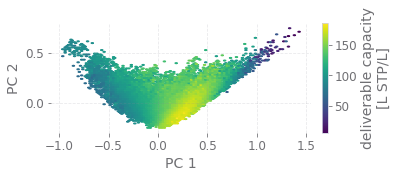

In [16]:
#low dimensional (PCA) visualization of the entire dataset
plt.hexbin(X_2D[:, 0], X_2D[:, 1], C=y)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
cb = plt.colorbar(fraction=0.02, pad=0.04)
cb.set_label(label="deliverable capacity\n[L STP/L]")
plt.xticks()
plt.yticks()
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
plt.savefig('feature_space_colored_by_DC.pdf')

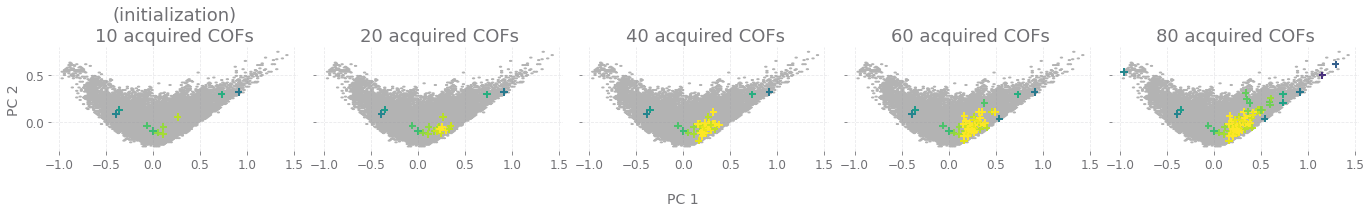

In [17]:
which_BO_run = 1

nb_acquired = [nb_COFs_initialization, 20, 40, 60, 80]
max_y_seen = np.zeros(len(nb_acquired))
fig, ax = plt.subplots(1, len(nb_acquired), sharey=True, sharex=True, figsize=[3*6.4, 4.8])
# gray background
for a in ax:
    a.set_aspect('equal', 'box')
    a.hexbin(X_2D[:, 0], X_2D[:, 1], C=0.3 * np.ones(nb_COFs), cmap="binary", vmin=0, vmax=1)
    
for i in range(len(nb_acquired)):
    ids_acquired = bo_res['ids_acquired'][which_BO_run][:nb_acquired[i]]
    max_y_seen[i] = np.max(y[ids_acquired])
    assert len(ids_acquired) == nb_acquired[i]
    # use above colorbar to assign color!
    ax[i].scatter(X_2D[ids_acquired, 0], X_2D[ids_acquired, 1], 
                  c=y[ids_acquired], marker="+", s=55, vmin=cb.vmin, vmax=cb.vmax)
    if i == 0:
        ax[i].set_title('(initialization)\n{} acquired COFs'.format(nb_acquired[i]))
    else:
        ax[i].set_title('{} acquired COFs'.format(nb_acquired[i]))
    ax[i].tick_params(axis='x')
ax[0].set_ylabel('PC 2', fontsize=14)

ax[2].tick_params(axis='y', labelsize=0)


fig.text(0.5, 0.2, 'PC 1', ha='center')
plt.tight_layout()
plt.savefig("feature_space_acquired_COFs.pdf", bbox_inches="tight")

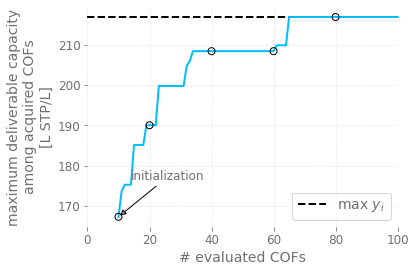

In [18]:
#search efficiency curve for this one.
y_maxes_this_run = np.array(
                    [np.max(y[bo_res['ids_acquired'][which_BO_run]][:i]) for i in range(1, 101)]
                    )
y_maxes_this_run[:nb_COFs_initialization-1] = np.NaN

plt.figure()
plt.plot(range(1, 101), y_maxes_this_run, color=search_to_color['BO'], clip_on=False)
# plt.scatter(nb_COFs_initialization, y_maxes_this_run[nb_COFs_initialization-1], color=search_to_color['BO'], marker="o")
plt.scatter(nb_acquired, max_y_seen, edgecolor="k", facecolor="None", zorder=100)
plt.xlabel('# evaluated COFs')
plt.ylabel('maximum deliverable capacity\namong acquired COFs\n[L STP/L]')
plt.annotate("initialization",
             xy=(nb_acquired[0], max_y_seen[0]), 
             xycoords='data',
             xytext=(nb_acquired[0]+16, max_y_seen[0]+10),
             textcoords='data',
             size=12, va="center", ha="center",
             arrowprops=dict(arrowstyle="-|>",
             fc=cool_colors[5], ec="k"), zorder=100000
)

plt.axhline(y=np.max(y), color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
# axs[0].set_ylim(ymin=0.0)
plt.xlim([0, 100])
plt.legend()

plt.tight_layout()
plt.savefig("search_efficiency_for_specific_acquisition_run.pdf")

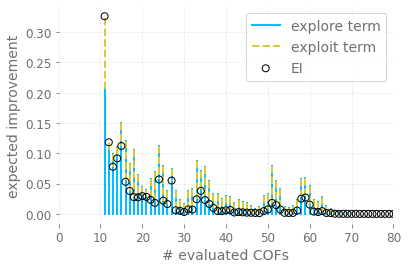

In [19]:
# explore vs exploit
explore_exploit_acquisition_terms = bo_res['explore_exploit_balance'][which_BO_run]

# ei term
explore_term = np.array([ee_i[0] for ee_i in explore_exploit_acquisition_terms])
exploit_term = np.array([ee_i[1] for ee_i in explore_exploit_acquisition_terms])

plt.figure()
plt.xlabel('# evaluated COFs')
plt.ylabel('expected improvement')
for i in range(nb_iterations):
    plt.plot([i+1, i+1], [0, explore_term[i]], color="C0")
    plt.plot([i+1, i+1], [explore_term[i], explore_term[i] + exploit_term[i]], color="C1", linestyle="--")
plt.plot([], [], color="C0", label="explore term")
plt.plot([], [], color="C1", label="exploit term", linestyle="--")
plt.scatter(np.arange(1, nb_iterations+1), explore_term + exploit_term, edgecolor="k", label="EI", zorder=100, facecolor="None")
plt.legend()
plt.xlim([0, 80])
plt.savefig("explore_exploit_balance.pdf", format="pdf")

# search efficiency
### max $y$ among acquired set.

In [20]:
# get y_max acquired up to iteration i for i = 1,2,...
def y_max(res, rank=False):
    y_max_mu      = np.zeros(nb_iterations)
    y_max_sig_bot = np.zeros(nb_iterations)
    y_max_sig_top = np.zeros(nb_iterations)
    for i in range(1, nb_iterations+1):
        # max value acquired up to this point
        if rank:
            y_maxes = np.array([np.min(y_ranks[res['ids_acquired'][r]][:i]) for r in range(nb_runs)]) # among runs
        else:
            y_maxes = np.array([np.max(y[res['ids_acquired'][r]][:i]) for r in range(nb_runs)]) # among runs
        assert np.size(y_maxes) == nb_runs
        y_max_mu[i-1]      = np.mean(y_maxes)
        y_max_sig_bot[i-1] = np.std(y_maxes[y_maxes < y_max_mu[i-1]])
        y_max_sig_top[i-1] = np.std(y_maxes[y_maxes > y_max_mu[i-1]])
    return y_max_mu, y_max_sig_bot, y_max_sig_top

y_max_mu_BO, y_max_sig_bot_BO, y_max_sig_top_BO = y_max(bo_res)
y_max_mu_es, y_max_sig_bot_es, y_max_sig_top_es = y_max(es_res)
y_max_mu_rs, y_max_sig_bot_rs, y_max_sig_top_rs = y_max(rs_res)

y_max_mu_BO_explore, y_max_sig_bot_BO_explore, y_max_sig_top_BO_explore = y_max(bo_res_explore)
y_max_mu_BO_exploit, y_max_sig_bot_BO_exploit, y_max_sig_top_BO_exploit = y_max(bo_res_exploit)

/home/cokes/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/cokes/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/cokes/.local/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NameError: name 'bo_res_explore' is not defined

In [21]:
def y_max_rf(res, rank=False): # put in an rf_res
    # one for each # of evaluation budgets
    y_max_mu      = np.zeros(len(res['nb_evals_budgets']))
    y_max_sig_bot = np.zeros(len(res['nb_evals_budgets']))
    y_max_sig_top = np.zeros(len(res['nb_evals_budgets']))
    for b in range(len(res['nb_evals_budgets'])):
        # get y max over runs.
        if rank:
            y_maxes = np.array([np.min(y_ranks[res['ids_acquired'][b][r]]) for r in range(nb_runs)])
        else:
            y_maxes = np.array([np.max(y[res['ids_acquired'][b][r]]) for r in range(nb_runs)])
        assert np.size(y_maxes) == nb_runs
        y_max_mu[b]      = np.mean(y_maxes)
        y_max_sig_bot[b] = np.std(y_maxes[y_maxes < y_max_mu[b]])
        y_max_sig_top[b] = np.std(y_maxes[y_maxes > y_max_mu[b]])
    return y_max_mu, y_max_sig_bot, y_max_sig_top    

In [22]:
y_max_mu_rf,     y_max_sig_bot_rf,     y_max_sig_top_rf     = y_max_rf(rf_res)
y_max_mu_rf_div, y_max_sig_bot_rf_div, y_max_sig_top_rf_div = y_max_rf(rf_div_res)

In [23]:
nb_iterations_range = np.arange(nb_iterations) + 1

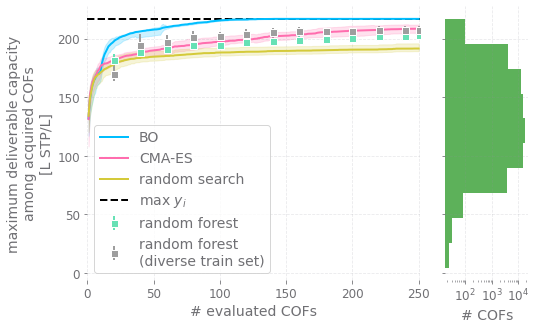

In [24]:
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize=[1.2 * 6.4, 4.8], sharey=True)
axs[0].plot(nb_iterations_range, y_max_mu_BO, label='BO', color=search_to_color['BO'], clip_on=False)
axs[0].fill_between(nb_iterations_range, y_max_mu_BO - y_max_sig_bot_BO, 
                                         y_max_mu_BO + y_max_sig_top_BO, 
                    alpha=0.2, ec="None", color=search_to_color['BO'])

# ES
axs[0].plot(nb_iterations_range, y_max_mu_es, label='CMA-ES', color=search_to_color['evolutionary'], clip_on=False)
axs[0].fill_between(nb_iterations_range, y_max_mu_es - y_max_sig_bot_es, 
                                         y_max_mu_es + y_max_sig_top_es, 
                    alpha=0.2, ec="None", color=search_to_color['evolutionary'])

# RS
axs[0].plot(nb_iterations_range, y_max_mu_rs, label='random search', color=search_to_color['random'], clip_on=False)
axs[0].fill_between(nb_iterations_range, y_max_mu_rs - y_max_sig_bot_rs, 
                                         y_max_mu_rs + y_max_sig_top_rs, 
                    alpha=0.2, ec="None", color=search_to_color['random'])

axs[0].set_xlabel('# evaluated COFs')
axs[0].set_ylabel('maximum deliverable capacity\namong acquired COFs\n[L STP/L]')


# RFs
axs[0].errorbar(rf_res['nb_evals_budgets'],     y_max_mu_rf,     yerr=np.vstack((y_max_sig_bot_rf,     y_max_sig_top_rf)),     color=search_to_color['RF'],       marker="s", label="random forest", linestyle="none")
axs[0].errorbar(rf_div_res['nb_evals_budgets'], y_max_mu_rf_div, yerr=np.vstack((y_max_sig_bot_rf_div, y_max_sig_top_rf_div)), color=search_to_color['RF (div)'], marker="s", label="random forest\n(diverse train set)", linestyle="none")

axs[0].axhline(y=np.max(y), color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
# axs[0].set_ylim(ymin=0.0)
axs[0].set_xlim([0, nb_iterations+1])
axs[0].legend()

axs[1].hist(y, orientation="horizontal", color=cool_colors[7])
axs[1].set_xlabel("# COFs")
axs[1].set_xscale("log")

plt.tight_layout()
plt.savefig("search_efficiency_max_found.pdf")

ylims_for_below = plt.gca().get_ylim()

full explore vs exploit

NameError: name 'y_max_mu_BO_explore' is not defined

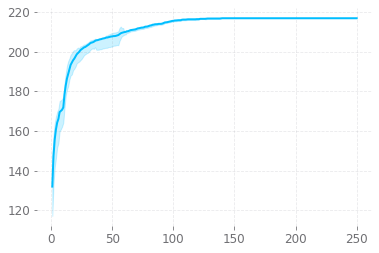

In [25]:
plt.figure()
plt.plot(nb_iterations_range, y_max_mu_BO, label='exploitation/exploration balance', color=search_to_color['BO'], clip_on=False)
plt.fill_between(nb_iterations_range, y_max_mu_BO - y_max_sig_bot_BO, 
                                      y_max_mu_BO + y_max_sig_top_BO, 
                    alpha=0.2, ec="None", color=search_to_color['BO'])

plt.plot(nb_iterations_range, y_max_mu_BO_explore, label='exploration', color="C6", clip_on=False)
plt.fill_between(nb_iterations_range, y_max_mu_BO_explore - y_max_sig_bot_BO_explore, 
                                      y_max_mu_BO_explore + y_max_sig_top_BO_explore, 
                    alpha=0.2, ec="None", color="C6")

plt.plot(nb_iterations_range, y_max_mu_BO_exploit, label='exploitation', color="C7", clip_on=False)
plt.fill_between(nb_iterations_range, y_max_mu_BO_exploit - y_max_sig_bot_BO_exploit, 
                                      y_max_mu_BO_exploit + y_max_sig_top_BO_exploit, 
                    alpha=0.2, ec="None", color="C7")

plt.xlabel('# evaluated COFs')
plt.ylabel('maximum deliverable capacity\namong acquired COFs\n[L STP/L]')
plt.legend()
plt.tight_layout()

### max rank among acquired set

In [28]:
y_max_mu_BO, y_max_sig_bot_BO, y_max_sig_top_BO = y_max(bo_res, rank=True)
y_max_mu_es, y_max_sig_bot_es, y_max_sig_top_es = y_max(es_res, rank=True)
y_max_mu_rs, y_max_sig_bot_rs, y_max_sig_top_rs = y_max(rs_res, rank=True)

y_max_mu_rf,     y_max_sig_bot_rf,     y_max_sig_top_rf     = y_max_rf(rf_res, rank=True)
y_max_mu_rf_div, y_max_sig_bot_rf_div, y_max_sig_top_rf_div = y_max_rf(rf_div_res, rank=True)

/home/cokes/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/cokes/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/cokes/.local/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


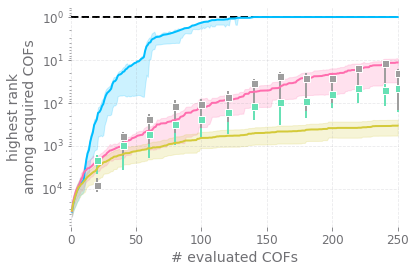

In [32]:
plt.figure()

plt.plot(nb_iterations_range, y_max_mu_BO, label='BO', color=search_to_color['BO'], clip_on=False)
plt.fill_between(nb_iterations_range, y_max_mu_BO - y_max_sig_bot_BO, 
                                      y_max_mu_BO + y_max_sig_top_BO, 
                 alpha=0.2, ec="None", color=search_to_color['BO'])

plt.plot(nb_iterations_range, y_max_mu_es, label='CMA-ES', color=search_to_color['evolutionary'], clip_on=False)
plt.fill_between(nb_iterations_range, y_max_mu_es - y_max_sig_bot_es, 
                                      y_max_mu_es + y_max_sig_top_es, 
                 alpha=0.2, ec="None", color=search_to_color['evolutionary'])

plt.plot(nb_iterations_range, y_max_mu_rs, label='random search', color=search_to_color['random'], clip_on=False)
plt.fill_between(nb_iterations_range, y_max_mu_rs - y_max_sig_bot_rs, 
                                      y_max_mu_rs + y_max_sig_top_rs, 
                 alpha=0.2, ec="None", color=search_to_color['random'])

# RFs
plt.errorbar(rf_res['nb_evals_budgets'],     y_max_mu_rf,     yerr=np.vstack((y_max_sig_bot_rf,     y_max_sig_top_rf)),     color=search_to_color['RF'],       marker="s", label="random forest", linestyle="None")
plt.errorbar(rf_div_res['nb_evals_budgets'], y_max_mu_rf_div, yerr=np.vstack((y_max_sig_bot_rf_div, y_max_sig_top_rf_div)), color=search_to_color['RF (div)'], marker="s", label="random forest\n(diverse train set)", linestyle="None")

plt.xlabel('# evaluated COFs')
plt.ylabel('highest rank\namong acquired COFs')
plt.xlim([0, nb_iterations+1])
# plt.ylim(ymin=1)
# plt.legend()
plt.axhline(y=1, color="k", linestyle="--", zorder=0) # to see the band bleed into negative zone.
plt.yticks()
plt.xticks()
plt.yscale("log")
plt.gca().invert_yaxis()
plt.tight_layout()
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.savefig("search_efficiency_rank.pdf")#, bbox_inches="tight")

print stats to report in paper

In [33]:
nb_bo_runs_to_get_top_cof = np.argmax(y_max_mu_BO == 1)
print("# evals by BO req'd to reach top COF in all runs:", nb_bo_runs_to_get_top_cof)

# evals by BO req'd to reach top COF in all runs: 139


In [34]:
y_max_mu_BO[nb_bo_runs_to_get_top_cof]

1.0

In [35]:
print("after ", rf_res['nb_evals_budgets'][-1],    "iterations, top-ranked COF found by RF:", y_max_mu_rf[-1])
print("after ", rf_div_res['nb_evals_budgets'][-1], "iterations, top-ranked COF found by RF (div):", y_max_mu_rf_div[-1])

print("after ", np.size(y_max_mu_es), "iterations, top-ranked COF found by CMA-ES:", y_max_mu_es[-1])
print("after ", np.size(y_max_mu_rs), "iterations, top-ranked COF found by rs:", y_max_mu_rs[-1])

after  250 iterations, top-ranked COF found by RF: 44.96
after  250 iterations, top-ranked COF found by RF (div): 20.58
after  250 iterations, top-ranked COF found by CMA-ES: 11.46
after  250 iterations, top-ranked COF found by rs: 340.45


### fraction of top 100 COFs recovered

In [36]:
top_100_COF_ids = np.flip(np.argsort(y))[:100]
assert np.size(top_100_COF_ids) == 100
print("top 100 COFs range from y =", np.min(y[top_100_COF_ids]), "to", np.max(y[top_100_COF_ids]))

top 100 COFs range from y = 195.43880373 to 216.894110699


In [37]:
def fraction_in_top100_cofs(ids_acquired):
    nb_in_top_100 = 0
    for id_acquired in ids_acquired:
        if id_acquired in top_100_COF_ids:
            nb_in_top_100 += 1
    return nb_in_top_100 / 100

In [38]:
# get fraction of aquired COFs in top 100 for
def y_top_100(res):
    y_top100_mu      = np.zeros(nb_iterations)
    y_top100_sig_bot = np.zeros(nb_iterations)
    y_top100_sig_top = np.zeros(nb_iterations)
    for i in range(1, nb_iterations+1):
        # max value acquired up to this point
        y_top100s = np.array([fraction_in_top100_cofs(res['ids_acquired'][r][:i]) for r in range(nb_runs)]) # among runs
        assert np.size(y_top100s) == nb_runs
        y_top100_mu[i-1]      = np.mean(y_top100s)
        y_top100_sig_bot[i-1] = np.std(y_top100s[y_top100s < y_top100_mu[i-1]])
        y_top100_sig_top[i-1] = np.std(y_top100s[y_top100s > y_top100_mu[i-1]])
    return y_top100_mu, y_top100_sig_bot, y_top100_sig_top

y_top100_mu_BO, y_top100_sig_bot_BO, y_top100_sig_top_BO = y_top_100(bo_res)
y_top100_mu_es, y_top100_sig_bot_es, y_top100_sig_top_es = y_top_100(es_res)
y_top100_mu_rs, y_top100_sig_bot_rs, y_top100_sig_top_rs = y_top_100(rs_res)

/home/cokes/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/cokes/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/cokes/.local/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [39]:
print("fraction of top 100 acquired after ", nb_bo_runs_to_get_top_cof, "runs:", y_top100_mu_BO[nb_bo_runs_to_get_top_cof])

fraction of top 100 acquired after  139 runs: 0.27760000000000007


In [40]:
def y_top_100_rf(rf_res, rank=False):
    # one for each # of evaluation budgets
    y_top100_mu      = np.zeros(len(rf_res['nb_evals_budgets']))
    y_top100_sig_bot = np.zeros(len(rf_res['nb_evals_budgets']))
    y_top100_sig_top = np.zeros(len(rf_res['nb_evals_budgets']))
    for b in range(len(rf_res['nb_evals_budgets'])):
        # get y max over runs.
        y_top100s = np.array([fraction_in_top100_cofs(rf_res['ids_acquired'][b][r]) for r in range(nb_runs)])
        assert np.size(y_top100s) == nb_runs
        y_top100_mu[b]      = np.mean(y_top100s)
        y_top100_sig_bot[b] = np.std(y_top100s[y_top100s < y_top100_mu[b]])
        y_top100_sig_top[b] = np.std(y_top100s[y_top100s > y_top100_mu[b]])
    return y_top100_mu, y_top100_sig_bot, y_top100_sig_top   

y_top100_mu_rf,    y_top100_sig_bot_rf,     y_top100_sig_top_rf     = y_top_100_rf(rf_res)
y_top100_mu_rf_div, y_top100_sig_bot_rf_div, y_top100_sig_top_rf_div = y_top_100_rf(rf_div_res)

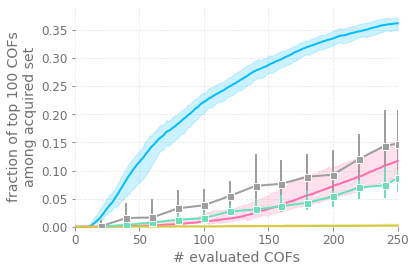

In [41]:
plt.figure()
plt.ylabel('fraction of top 100 COFs\namong acquired set')
plt.xlabel('# evaluated COFs')

plt.plot(nb_iterations_range, y_top100_mu_BO, label='BO', color=search_to_color['BO'], clip_on=False)
plt.fill_between(nb_iterations_range, y_top100_mu_BO - y_top100_sig_bot_BO, 
                                      y_top100_mu_BO + y_top100_sig_top_BO, 
                 alpha=0.2, ec="None", color=search_to_color['BO'])

plt.plot(nb_iterations_range, y_top100_mu_es, label='CMA-ES', color=search_to_color['evolutionary'], clip_on=False)
plt.fill_between(nb_iterations_range, y_top100_mu_es - y_top100_sig_bot_es, 
                                      y_top100_mu_es + y_top100_sig_top_es, 
                 alpha=0.2, ec="None", color=search_to_color['evolutionary'])

plt.plot(nb_iterations_range, y_top100_mu_rs, label='random search', color=search_to_color['random'], clip_on=False)
plt.fill_between(nb_iterations_range, y_top100_mu_rs - y_top100_sig_bot_rs, 
                                      y_top100_mu_rs + y_top100_sig_top_rs, 
                 alpha=0.2, ec="None", color=search_to_color['random'])

# RFs
plt.errorbar(rf_res['nb_evals_budgets'],     y_top100_mu_rf,     yerr=np.vstack((y_top100_sig_bot_rf,     y_top100_sig_top_rf)),     color=search_to_color['RF'],       marker="s", label="random forest")
plt.errorbar(rf_div_res['nb_evals_budgets'], y_top100_mu_rf_div, yerr=np.vstack((y_top100_sig_bot_rf_div, y_top100_sig_top_rf_div)), color=search_to_color['RF (div)'], marker="s", label="random forest\n(diverse train set)")

plt.xlim([0, 250])
plt.ylim(ymin=0.0)
plt.xticks()
plt.yticks()
plt.tight_layout()
plt.savefig("search_efficiency_top100.pdf", format="pdf")

In [46]:
print("after ", rf_res['nb_evals_budgets'][-1],    "iterations, fraction top 100 COFs found by RF:", y_top100_mu_rf[-1])
print("after ", rf_div_res['nb_evals_budgets'][-1], "iterations, fraction top 100 COFs found by RF (div):", y_top100_mu_rf_div[-1])

print("after ", np.size(y_top100_mu_BO), "iterations, fraction top 100 COFs found by BO:", y_top100_mu_BO[-1])
print("after ", np.size(y_top100_mu_es), "iterations, fraction top 100 COFs found by CMA-ES:", y_top100_mu_es[-1])
print("after ", np.size(y_top100_mu_rs), "iterations, fraction top 100 COFs found by RS:", y_top100_mu_rs[-1])

after  250 iterations, fraction top 100 COFs found by RF: 0.08650000000000001
after  250 iterations, fraction top 100 COFs found by RF (div): 0.14790000000000003
after  250 iterations, fraction top 100 COFs found by BO: 0.3619
after  250 iterations, fraction top 100 COFs found by CMA-ES: 0.11720000000000001
after  250 iterations, fraction top 100 COFs found by RS: 0.0021


## look at how search efficiency changes for BO in terms of the number of initially acquired COFs

In [47]:
# load in array of # of COFs initialized
nb_COFs_initializeds = pickle.load(open('bo_results_nb_COF_initializations.pkl', 'rb'))['EI']
nb_COFs_initializeds

[5, 10, 15, 20, 25]

In [48]:
# color curves according to # COFs used in the init
cmap = sns.color_palette("flare", as_cmap=True)

def nb_COFs_to_color(x):
    the_range = np.max(nb_COFs_initializeds) - np.min(nb_COFs_initializeds)
    return cmap((x - np.min(nb_COFs_initializeds)) / the_range)

/home/cokes/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/cokes/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/cokes/.local/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/cokes/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/cokes/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/cokes/.local/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret

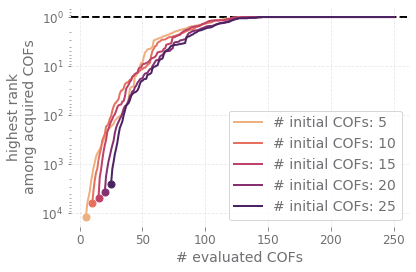

In [50]:
# load in BO results for each number of initialized COFs
bo_ress = [pickle.load(open('bo_results_EI' + "_initiate_with_{0}".format(nb_COFs_initialized) + '.pkl', 'rb')) for nb_COFs_initialized in nb_COFs_initializeds]
for res in bo_ress:
    assert len(res['ids_acquired']) == nb_runs
    assert len(res['ids_acquired'][0]) == nb_iterations

# plot
plt.figure()
for i in range(len(nb_COFs_initializeds)):
    the_bo_res = bo_ress[i]
    y_max_mu, _, _ = y_max(the_bo_res, rank=True)
    y_max_mu[:(nb_COFs_initializeds[i]-1)] = np.NaN # cuz just random
    
    plt.scatter([nb_COFs_initializeds[i]], [y_max_mu[nb_COFs_initializeds[i]-1]], color=nb_COFs_to_color(nb_COFs_initializeds[i]))
    plt.plot(nb_iterations_range, y_max_mu, label='# initial COFs: {}'.format(nb_COFs_initializeds[i]), color=nb_COFs_to_color(nb_COFs_initializeds[i]), clip_on=False)
    # TODO make shaded thing

plt.xlabel('# evaluated COFs')
plt.ylabel('highest rank\namong acquired COFs')
# plt.xlim([0, 250])
# plt.ylim(ymin=1)
# plt.legend(fontsize=1/4)
plt.axhline(y=1, color="k", linestyle="--", zorder=0) # to see the band bleed into negative zone.
plt.yticks()
plt.xticks()
plt.yscale("log")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("bo_search_res_with_different_cof_inits.pdf", format="pdf")